# Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# xgboost
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from kneed import KneeLocator

# logreg / rfe
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# to display all rows in dataframes
pd.set_option('display.max_rows', None) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load data

In [2]:
df = pd.read_csv("../data/grouped_data.csv")
X_train = pd.read_csv("../data/X_train_final.csv")
X_test = pd.read_csv("../data/X_test_final.csv")
y_train = pd.read_csv("../data/y_train_final.csv")
y_test = pd.read_csv("../data/y_test_final.csv")

In [3]:
# one hot encode the categories
features_nominal = ['order_1', 'order_2', 'order_3', 'order_6', 'order_7']
X_train = pd.get_dummies(X_train, columns = features_nominal)
X_test = pd.get_dummies(X_test, columns = features_nominal)

# Feature Selection

In [5]:
impt_feat = []

## XGB feature importance

In [6]:
# fit model to training data
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, xgb.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame(feats.items(), columns=['Feature', 'Importance'])
#.rename(columns={0: 'importance'})
importances = importances.sort_values(by = ['Importance'], ascending = False)
impt_feat.extend(importances.Feature.iloc[0:30].tolist())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

[20:45:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [7]:
impt_feat

['order_2_G',
 'count_G',
 'order_6_T',
 'order_7_A',
 'mean_current_2_median',
 'sd_current_2_median',
 'mean_current_2_std',
 'mean_current_3_std',
 'sd_current_2_min',
 'diff_mean_current_2_median',
 'order_7_G',
 'order_6_A',
 'mean_current_3_median',
 'order_7_T',
 'sd_current_2_std',
 'diff_mean_current_2_max',
 'mean_current_2_min',
 'diff_mean_current_1_min',
 'diff_mean_current_1_median',
 'mean_current_2_max',
 'mean_current_3_min',
 'mean_current_1_median',
 'order_2_A',
 'relative_position',
 'sd_current_3_median',
 'mean_current_1_max',
 'order_7_C',
 'mean_current_1_std',
 'count_T',
 'order_1_T']

## PCA dimensionality reduction

Remove categorical features

In [8]:
df_pca = df.drop(columns = ['label', 'sevenmers', 'gene_id', 'transcript_id', 'order_1', 'order_2', 'order_3', 'order_6', 'order_7'])

In [9]:
_ , p_value = calculate_bartlett_sphericity(df_pca)
p_value

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/factor_analyzer/factor_analyzer.py:108: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


nan

In [10]:
_, kmo_score = calculate_kmo(df_pca)
kmo_score 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.8367291595433709

As p-value < 0.5 and kmo score > 0.5, PCA is suitable on the dataframe.

In [11]:
fa = FactorAnalyzer(n_factors = 10, method = 'principal', rotation='varimax')
fa.fit(df_pca)
eigenvalues, _ = fa.get_eigenvalues()
variances = fa.get_factor_variance()

Text(0, 0.5, 'Proportion of Variance Explained by PC')

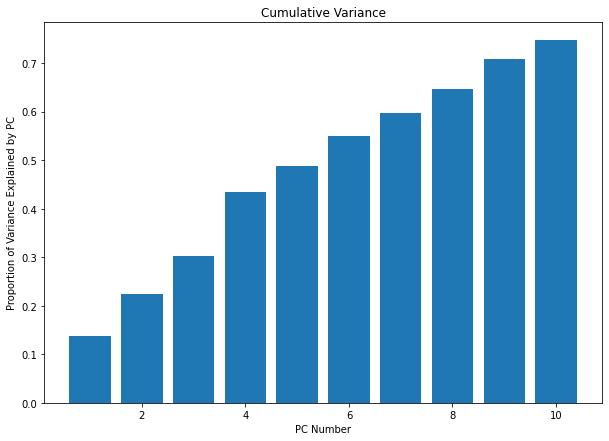

In [12]:
x = list(range(1,11))
plt.figure(figsize=(10, 7)) 
plt.bar(x,variances[2])
plt.title('Cumulative Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')

In [13]:
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x):
        if x <= -0.7 or x >= 0.7:
            return x
        else:
            return("")    
    # REMARK: we use 'principal' method and 'varimax' rotation in the FactorAnalyzer function.
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax')
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    return loadings

# The following function generates the rotation matrix. Recall that we use
# this matrix to determine if the PCs generated are easily understandable and appropriate.
# The argument "num_of_pcs" specifies, the number of PCs we wish to generate.

In [14]:
def variance_explained(num_of_pcs,data):
    # REMARK: we use 'principal' method and 'varimax' rotation in the FactorAnalyzer function.
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax')
    f.fit(data)
    return f.get_factor_variance()[2][num_of_pcs-1]

# The following function calculates the variance explained by the specified desired number of PCs.

Chose 9 PCs as it explains >70% of the variance

In [15]:
variance_explained(9, df_pca)

0.7219339478857075

In [16]:
evaluate_pcs(9,df_pca)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
transcript_position,,,,,,,,,
dwelling_time_1_min,,,,,,,,,
dwelling_time_1_max,,,,,,,,,0.794011
dwelling_time_1_median,,,,,,,,,0.757115
dwelling_time_1_std,,,,,,,,,0.849693
sd_current_1_min,,,,,,,,,
sd_current_1_max,,,,,,,,,
sd_current_1_median,,0.827938,,,,,,,
sd_current_1_std,,,,,,,,,
mean_current_1_min,,0.744913,,,,,,,


Drop the columns that are not in any PCs as they are not as important.

In [17]:
new_df = df.drop(columns = ['transcript_position', 'dwelling_time_1_min',
                           'sd_current_1_min', 'sd_current_1_max', 'sd_current_1_std',
                           'mean_current_1_std', 'dwelling_time_2_min', 'dwelling_time_2_median',
                           'sd_current_2_min', 'mean_current_2_min', 'mean_current_2_max', 'mean_current_2_median',
                           'mean_current_2_std', 'dwelling_time_3_min', 'sd_current_3_min',
                           'mean_current_3_std', 'diff_dwelling_time_1_median', 'diff_dwelling_time_1_std',
                           'diff_dwelling_time_2_median', 'diff_sd_current_1_min', 'diff_sd_current_1_median',
                           'diff_mean_current_1_max', 'diff_mean_current_1_std', 'diff_mean_current_2_min',
                           'diff_mean_current_2_median', 'relative_position', 'count_A', 'count_C', 'count_G', 'count_T'])

In [18]:
cols2keep_pca = new_df.columns
impt_feat.extend(new_df.columns)

## RFE Recursive Feature Elimination

In [19]:
logreg = LogisticRegression(max_iter=1000)

In [20]:
rfe3 = RFE(logreg, n_features_to_select=30)
rfe3 = rfe3.fit(X_train, y_train.values.ravel())

In [21]:
# cols remaining
cols_keep = X_train.columns.values[rfe3.support_]
impt_feat.extend(cols_keep)

In [22]:
impt_feat

['order_2_G',
 'count_G',
 'order_6_T',
 'order_7_A',
 'mean_current_2_median',
 'sd_current_2_median',
 'mean_current_2_std',
 'mean_current_3_std',
 'sd_current_2_min',
 'diff_mean_current_2_median',
 'order_7_G',
 'order_6_A',
 'mean_current_3_median',
 'order_7_T',
 'sd_current_2_std',
 'diff_mean_current_2_max',
 'mean_current_2_min',
 'diff_mean_current_1_min',
 'diff_mean_current_1_median',
 'mean_current_2_max',
 'mean_current_3_min',
 'mean_current_1_median',
 'order_2_A',
 'relative_position',
 'sd_current_3_median',
 'mean_current_1_max',
 'order_7_C',
 'mean_current_1_std',
 'count_T',
 'order_1_T',
 'gene_id',
 'transcript_id',
 'sevenmers',
 'dwelling_time_1_max',
 'dwelling_time_1_median',
 'dwelling_time_1_std',
 'sd_current_1_median',
 'mean_current_1_min',
 'mean_current_1_max',
 'mean_current_1_median',
 'dwelling_time_2_max',
 'dwelling_time_2_std',
 'sd_current_2_max',
 'sd_current_2_median',
 'sd_current_2_std',
 'dwelling_time_3_max',
 'dwelling_time_3_median',
 

In [23]:
len(impt_feat)

105

## Feature Importance using Random Forest

In [25]:
# baseline model with default parameters
import time
start = time.time()
forest1 = RandomForestClassifier(random_state = 1, n_jobs= -1)
forest1.fit(X_train,y_train.values.ravel())
end = time.time()
print("Time taken:", (end-start)/60, "minutes")

Time taken: 0.16238723198572794 minutes


In [26]:
rf_y_pred = forest1.predict(X_test)
y_predict_prob = forest1.predict_proba(X_test)[:, 1]

In [31]:
print(metrics.confusion_matrix(y_test, rf_y_pred))
# TN FP
# FN TP

print(f'accuracy:  {metrics.accuracy_score(y_test, rf_y_pred)}')
print(f'precision: {metrics.precision_score(y_test,rf_y_pred)}')
print(f'recall:    {metrics.recall_score(y_test, rf_y_pred)}')
print(f'roc auc:   {metrics.roc_auc_score(y_test, y_predict_prob)}')
print(f'pr auc:    {metrics.average_precision_score(y_test, y_predict_prob)}')

[[22638    10]
 [ 1142    42]]
accuracy:  0.9516616314199395
precision: 0.8076923076923077
recall:    0.03547297297297297
roc auc:   0.8853000600554193
pr auc:    0.43620064523413266


In [28]:
importance = forest1.feature_importances_
importance

array([0.01395653, 0.00374602, 0.00758862, 0.00805715, 0.00827251,
       0.01407375, 0.00898533, 0.01394559, 0.00919603, 0.02220908,
       0.02149772, 0.03235918, 0.01456666, 0.00420299, 0.00685159,
       0.00980081, 0.00801862, 0.0248702 , 0.01305456, 0.03686503,
       0.01881155, 0.01761501, 0.01210491, 0.03329846, 0.03218852,
       0.00409558, 0.00723165, 0.00844575, 0.0081595 , 0.01010617,
       0.00761643, 0.01097902, 0.00881484, 0.02060769, 0.01241749,
       0.02020304, 0.02846753, 0.00765949, 0.00771847, 0.00943806,
       0.00824396, 0.007577  , 0.00759859, 0.00958686, 0.00794978,
       0.01034081, 0.01036823, 0.02325254, 0.01429974, 0.01217155,
       0.00841054, 0.0207334 , 0.01721824, 0.01267332, 0.01011022,
       0.02112571, 0.01176339, 0.01730397, 0.01552962, 0.03060771,
       0.01483362, 0.01446606, 0.01086497, 0.00183488, 0.01795844,
       0.00599975, 0.00100652, 0.00056192, 0.0009099 , 0.00103512,
       0.00368559, 0.02256013, 0.00352559, 0.00426911, 0.00147

In [29]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, forest1.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame(feats.items(), columns=['Feature', 'Importance'])
#.rename(columns={0: 'importance'})
importances = importances.sort_values(by = ['Importance'], ascending = False)
importances

,Feature,Importance
19,sd_current_2_median,0.036865
23,mean_current_2_median,0.033298
11,mean_current_1_median,0.032359
24,mean_current_2_std,0.032189
77,order_6_T,0.031320
59,diff_mean_current_2_median,0.030608
36,mean_current_3_std,0.028468
17,sd_current_2_min,0.024870
47,diff_sd_current_1_median,0.023253
71,order_2_G,0.022560


In [32]:
importances.Feature.iloc[0: 30].tolist()

['sd_current_2_median',
 'mean_current_2_median',
 'mean_current_1_median',
 'mean_current_2_std',
 'order_6_T',
 'diff_mean_current_2_median',
 'mean_current_3_std',
 'sd_current_2_min',
 'diff_sd_current_1_median',
 'order_2_G',
 'mean_current_1_min',
 'mean_current_1_max',
 'diff_mean_current_1_median',
 'diff_sd_current_2_median',
 'mean_current_3_min',
 'mean_current_3_median',
 'sd_current_2_std',
 'count_G',
 'mean_current_2_min',
 'diff_mean_current_2_min',
 'diff_sd_current_2_std',
 'diff_mean_current_2_max',
 'diff_mean_current_2_std',
 'mean_current_1_std',
 'relative_position',
 'diff_sd_current_1_std',
 'sd_current_1_min',
 'transcript_position',
 'sd_current_1_median',
 'sd_current_2_max']

In [33]:
impt_feat.extend(importances.Feature.iloc[0: 30].tolist())

# Check the Frequencies

In [34]:
features = pd.DataFrame(impt_feat)
features.value_counts()

diff_mean_current_1_median    4
sd_current_2_median           4
mean_current_1_median         4
diff_mean_current_2_max       4
mean_current_3_median         4
mean_current_1_max            4
sd_current_2_std              4
order_6_T                     3
mean_current_3_std            3
diff_sd_current_2_std         3
mean_current_3_min            3
sd_current_2_min              3
mean_current_2_std            3
mean_current_1_std            3
mean_current_1_min            3
sd_current_3_median           3
count_G                       3
mean_current_2_median         3
diff_mean_current_2_std       3
diff_sd_current_1_std         3
mean_current_3_max            2
mean_current_2_min            2
relative_position             2
mean_current_2_max            2
sd_current_1_median           2
diff_mean_current_1_min       2
diff_sd_current_1_median      2
sd_current_2_max              2
diff_mean_current_2_median    2
dwelling_time_3_max           2
diff_sd_current_2_median      2
sd_curre

We will thus select features where the value counts are >= 2